In [30]:
import os
import sys
import toml
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as tkr 
import matplotlib.dates as md
import matplotlib.pyplot as plt
from distutils.version import StrictVersion

sns.set_theme()

In [16]:
from lib import DBClient, lib_plot, NodeClassification
from lib.lib_udger import UdgerClient
from lib.lib_agent import polkadot_version
from lib.lib_fmt import fmt_thousands

In [3]:
now = dt.datetime.today()
year = os.getenv('NEBULA_REPORT_YEAR', now.year)
calendar_week = os.getenv('NEBULA_REPORT_WEEK', now.isocalendar().week - 1)


output_dir = './polkadot'
output_file = os.path.join(output_dir, f"report-{calendar_week}.md")
plots_dir = os.path.join(output_dir, f"plots-{calendar_week}")
if not os.path.isdir(plots_dir):
    os.mkdir(plots_dir)

if os.path.isfile("db.toml"):
    with open("db.toml", "r") as config_file:
        db_config = toml.load(config_file)["psql"]
else:
    db_config = {
        'host': os.environ['NEBULA_DATABASE_HOST'],
        'port': os.environ['NEBULA_DATABASE_PORT'],
        'database': os.environ['NEBULA_DATABASE_NAME'],
        'user': os.environ['NEBULA_DATABASE_USER'],
        'password': os.environ['NEBULA_DATABASE_PASSWORD'],
        'sslmode': os.environ['NEBULA_DATABASE_SSL_MODE'],
    }


print(f'Generating report for year {year}, week {calendar_week}')
print(f'Writing report to {output_file}')
print(f'Writing plots to {plots_dir}')
print('Using database connection with:')
print('host: ' + db_config['host'])
print('port: ' + db_config['port'])
print('database: ' + db_config['database'])
print('user: ' + db_config['user'])
print('sslmode: ' + db_config['sslmode'])

Generating report for year 2023, week 41
Writing report to ./polkadot/report-41.md
Writing plots to ./polkadot/plots-41
Using database connection with:
host: cmi-read.cla0ai5jnqlv.us-east-1.rds.amazonaws.com
port: 5432
database: nebula_polkadot
user: nebula_polkadot_ro
sslmode: require


In [4]:
db_client = DBClient(year=year, calendar_week=calendar_week, db_config=db_config)

Initializing database client...


In [5]:
udger_db_file = os.getenv('NEBULA_REPORT_UDGER_DB', 'udgerdb_v3.dat')
udger_available = os.path.exists(udger_db_file)
if udger_available:
    print('Using udger database')
    udger_client = UdgerClient(udger_db_file)

Using udger database


In [6]:
crawl_count = db_client.get_crawl_count()
visit_count = db_client.get_visit_count()
visited_peer_id_count = db_client.get_visited_peer_id_count()
discovered_peer_id_count = db_client.get_discovered_peer_id_count()
ip_address_count = db_client.get_ip_addresses_count()
top_rotating_nodes = db_client.get_top_rotating_nodes()

Using cache file .cache/get_crawl_count-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_crawl_count...
Using cache file .cache/get_visit_count-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_visit_count...
Using cache file .cache/get_visited_peer_id_count-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_visited_peer_id_count...
Using cache file .cache/get_discovered_peer_id_count-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_discovered_peer_id_count...
Using cache file .cache/get_ip_addresses_count-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_ip_addresses_count...
Using cache file .cache/get_top_rotating_nodes-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.pickle for get_top_rotating_nodes...


In [7]:
df_conn = db_client.get_connection_errors()
df_crawl = db_client.get_crawl_errors()

Using cache file .cache/get_connection_errors-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.pickle for get_connection_errors...
Using cache file .cache/get_crawl_errors-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.pickle for get_crawl_errors...


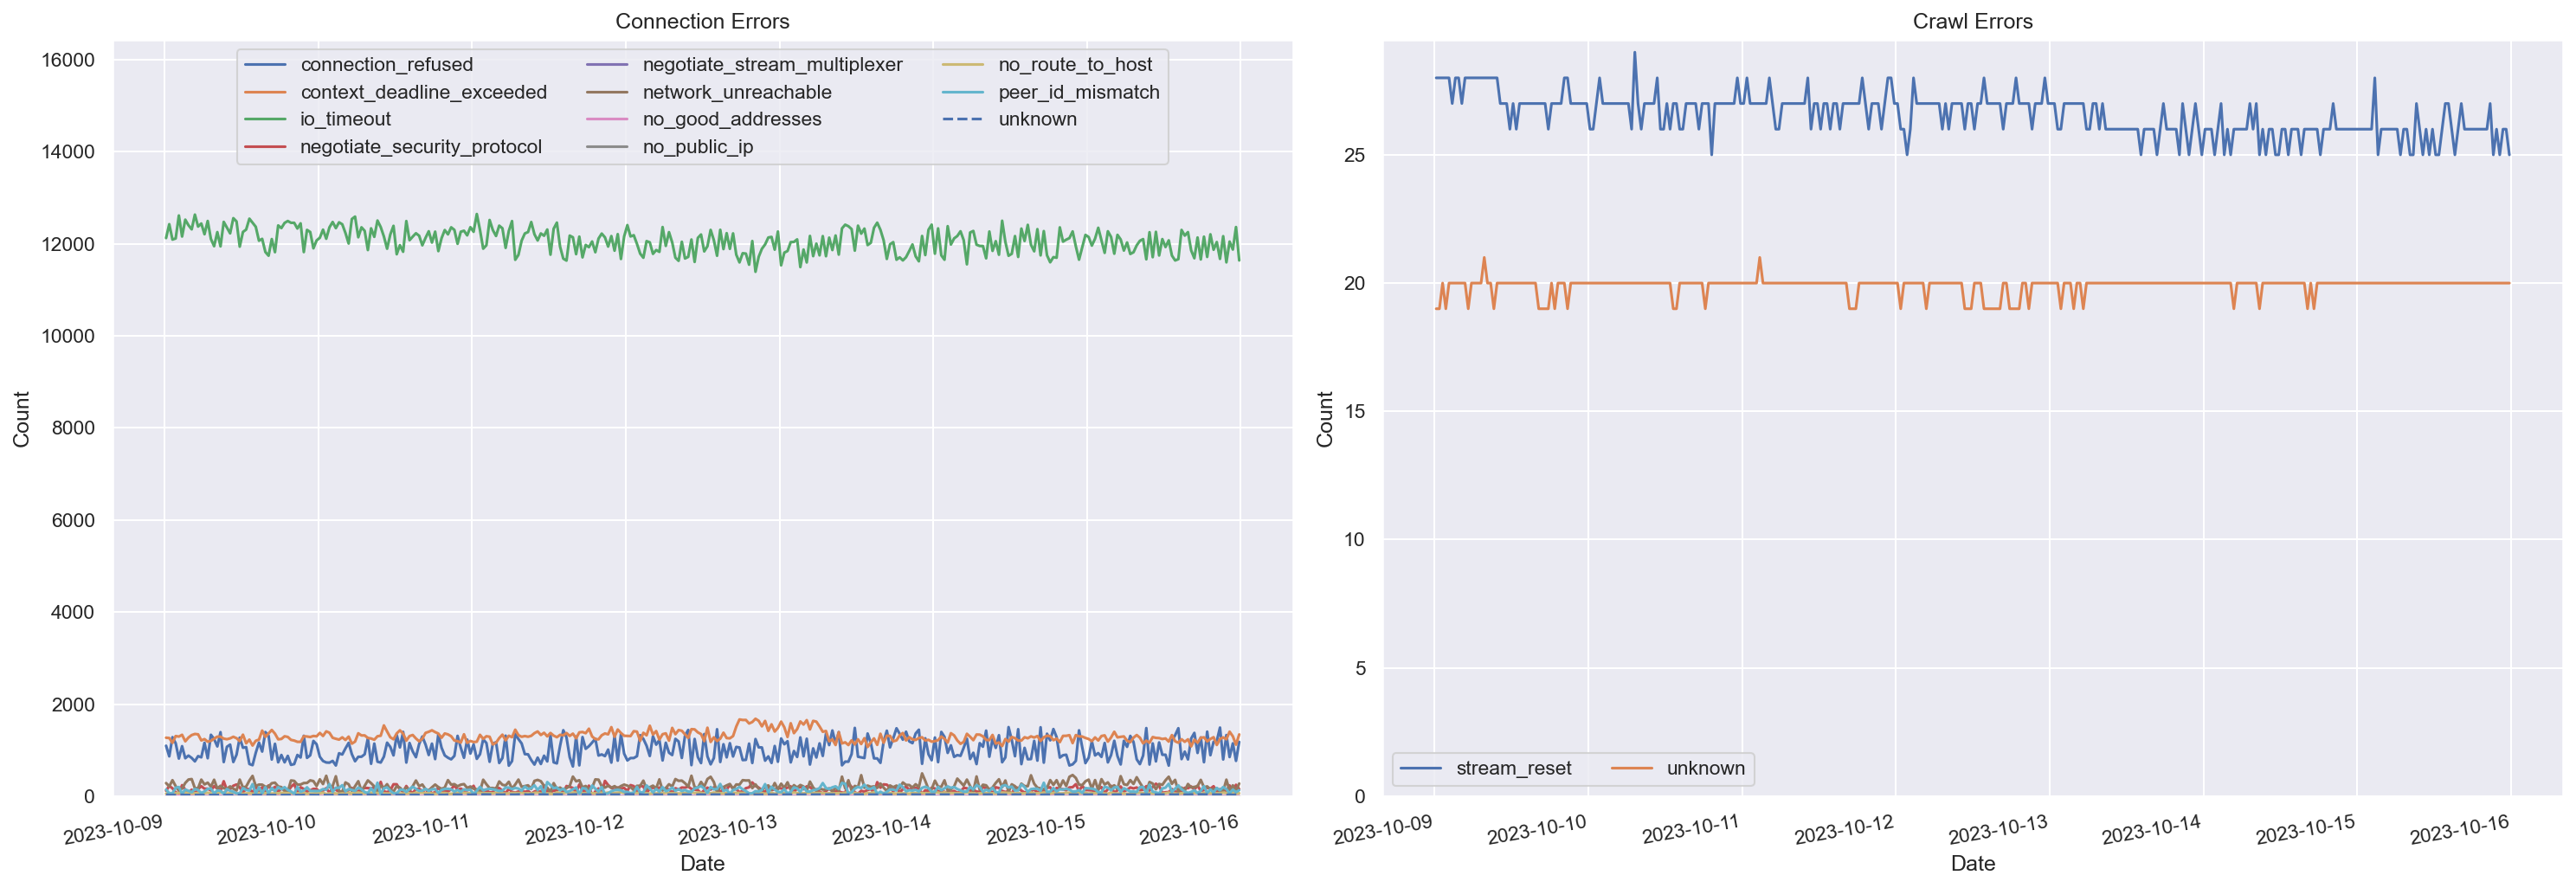

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 7], dpi=150)

for idx, error in enumerate(sorted(df_conn["error"].unique())):
    data = df_conn[df_conn["error"] == error]
    ls = "solid"
    if idx >= 10:
        ls = "dashed"
    ax1.plot(data["started_at"], data["count"], label=error, ls=ls)

ax1.set_ylim(0, df_conn["count"].max()*1.3)
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
for tick in ax1.get_xticklabels():
    tick.set_rotation(10)
    tick.set_ha('right')
ax1.legend(loc='upper center', ncol=3)
ax1.set_title("Connection Errors")

for idx, error in enumerate(sorted(df_crawl["error"].unique())):
    data = df_crawl[df_crawl["error"] == error]
    ls = "solid"
    if idx >= 10:
        ls = "dashed"
    ax2.plot(data["started_at"], data["count"], label=error, ls=ls)

ax2.set_ylim(0)
ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
for tick in ax2.get_xticklabels():
    tick.set_rotation(10)
    tick.set_ha('right')
ax2.legend(ncol=2)
ax2.set_title("Crawl Errors")

fig.set_tight_layout(True)
lib_plot.savefig(fig, "crawl-errors", dir_name=plots_dir)

In [43]:
df = db_client.get_agent_versions_distribution(with_storm=False)
clients = []
majors = []
minors = []
patches = []
versions = []
for row in df.iterrows():
    agent = polkadot_version(row[1]["agent_version"])
    if agent is None:
        clients += [None]
        majors += [None]
        minors += [None]
        patches += [None]
        versions += [None]
    else:
        clients += [agent.client]
        majors += [agent.major]
        minors += [agent.minor]
        patches += [agent.patch]
        versions += [agent.version()]

df["client"] = pd.Series(clients)
df["major"] = pd.Series(majors)
df["minor"] = pd.Series(minors)
df["patch"] = pd.Series(patches)
df["version"] = pd.Series(versions)

df_agent_versions = df.copy()

Using cache file .cache/get_agent_versions_distribution-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.pickle for get_agent_versions_distribution...


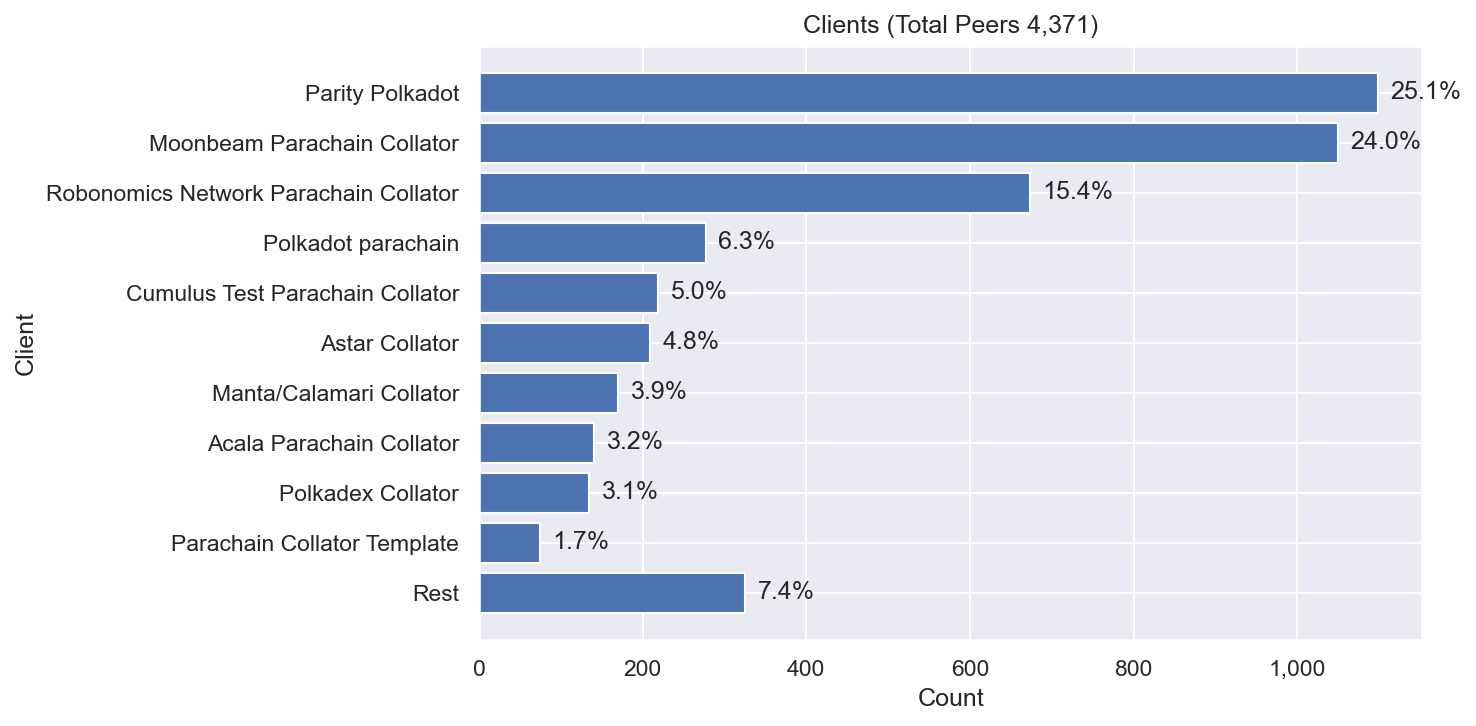

In [39]:
df = df_agent_versions.copy() \
    .groupby(by=["client"], as_index=False) \
    .sum(numeric_only=True) \
    .sort_values(["count"], ascending=False) \
    .reset_index(drop=True)

result = df.nlargest(10, columns="count")
other_count = df.loc[~df["client"].isin(result["client"]), "count"].sum()

if other_count > 0:
    result.loc[len(result)] = ['Rest', 0, other_count]

df = result

total = df['count'].sum()

fig, ax = plt.subplots(figsize=[10, 5], dpi=150)

p1 = ax.barh(df["client"], df["count"])
ax.set_yticks(df["client"], labels=[client for client in df["client"]])
ax.set_xlabel("Count")
ax.set_ylabel("Client")

ax.bar_label(p1, padding=6, labels=["%.1f%%" % (100*val/total) for val in df["count"]])

ax.set_title(f"Clients (Total Peers {fmt_thousands(total)})")
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.invert_yaxis()
fig.set_tight_layout(True)
lib_plot.savefig(fig, "agents-polkadot-clients", dir_name=plots_dir)

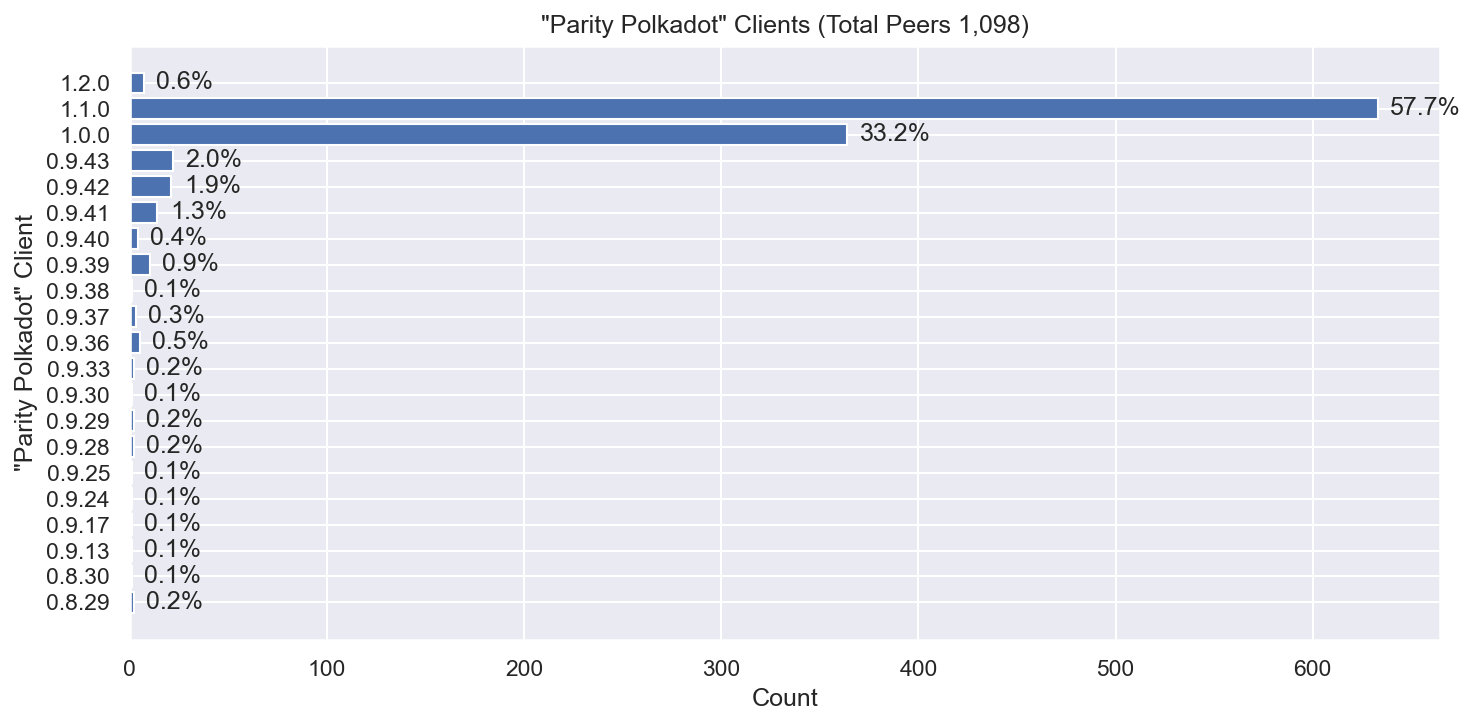

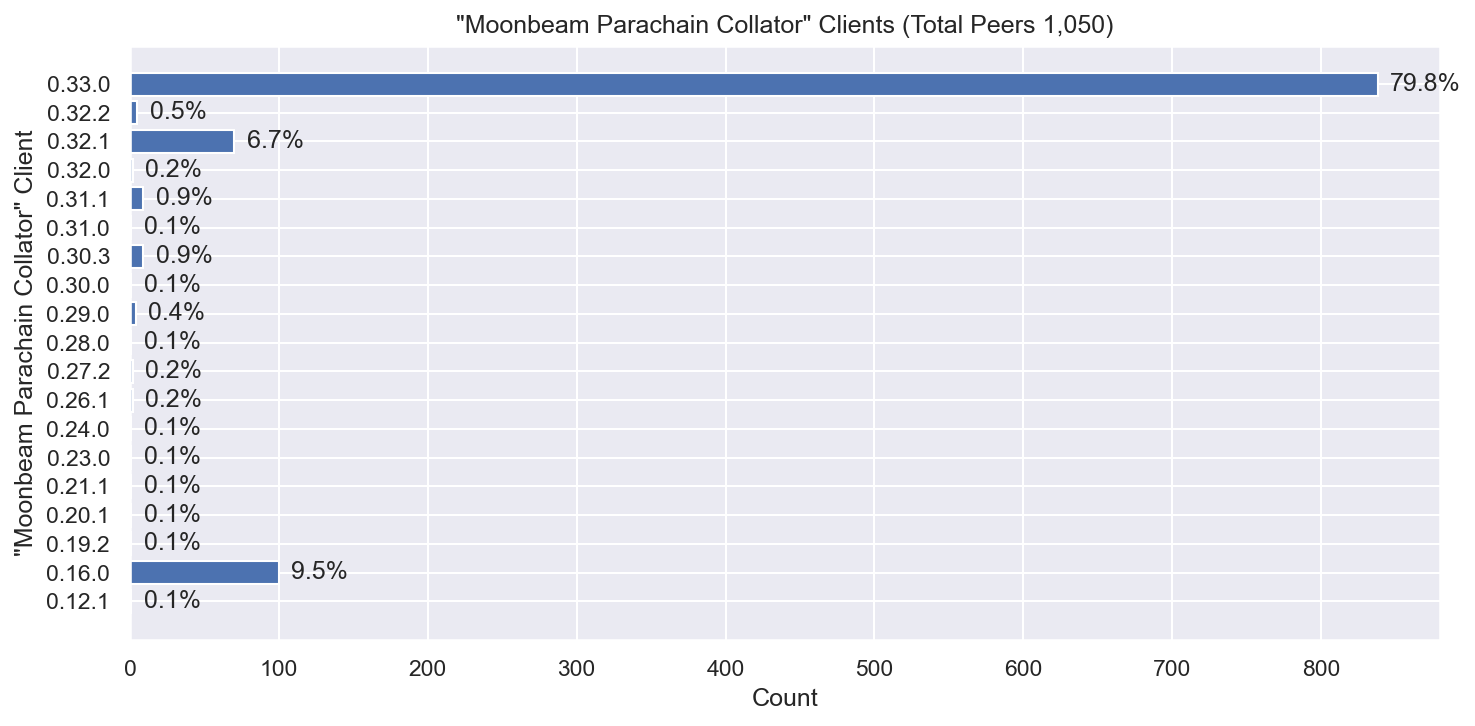

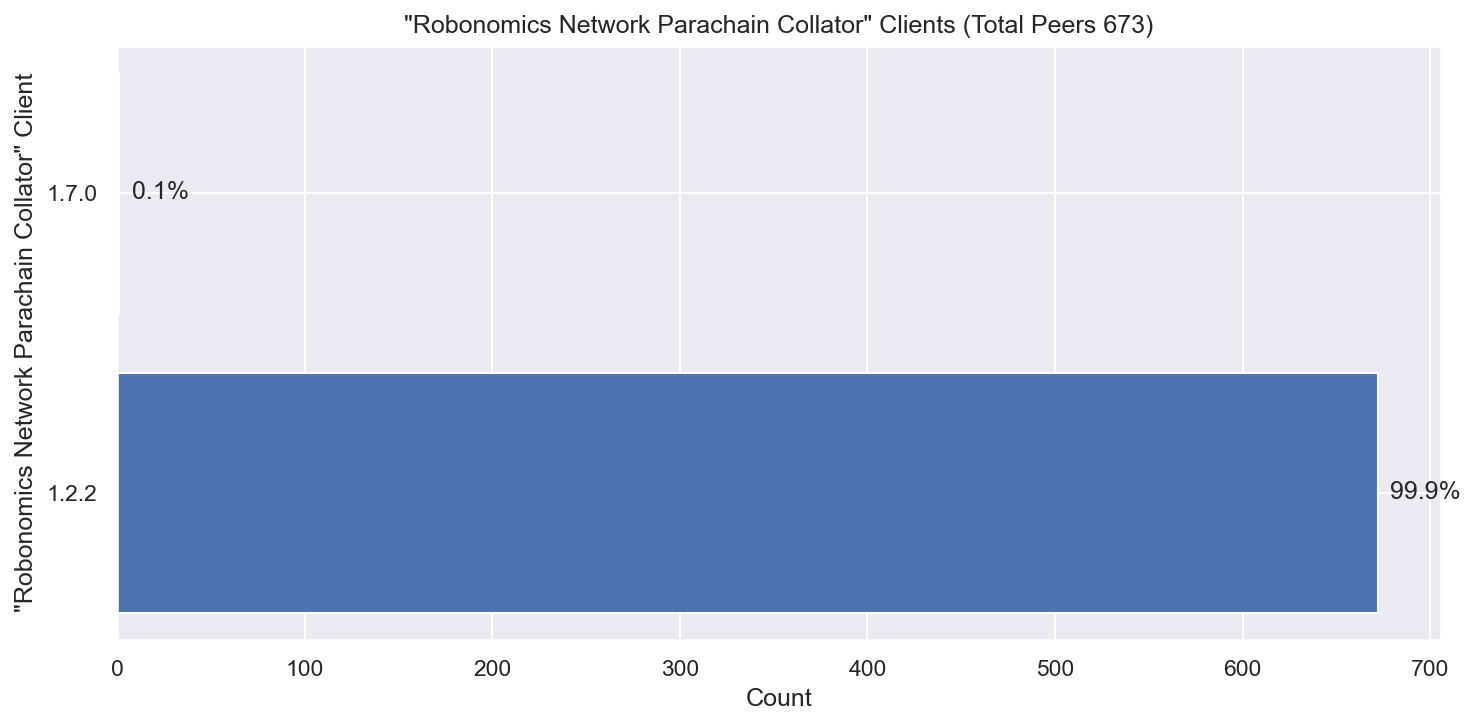

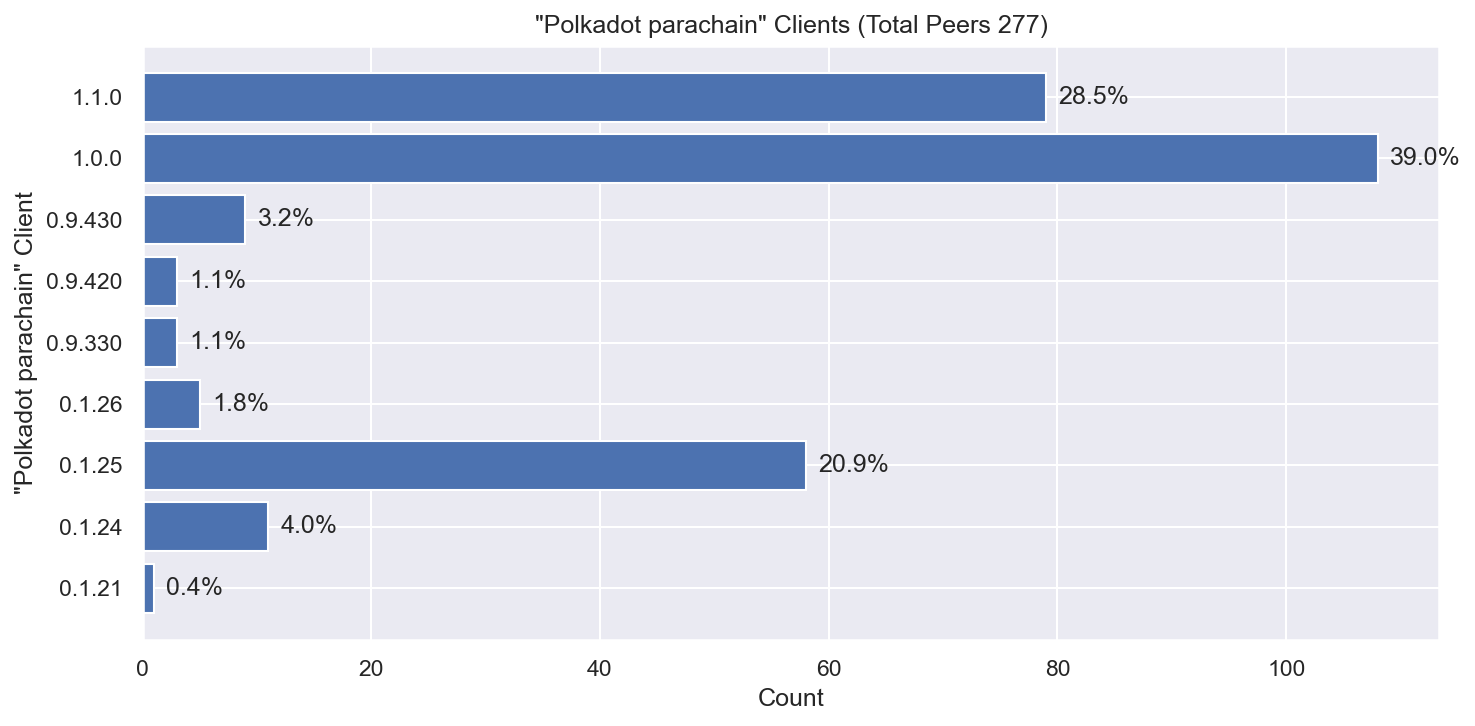

In [53]:
clients = [
    "Parity Polkadot",
    "Moonbeam Parachain Collator",
    "Robonomics Network Parachain Collator",
    "Polkadot parachain"
]

for client in clients:
    df = df_agent_versions.copy()
    
    df = df[df["client"] == client]
    
    df = df \
        .groupby(by=["version"], as_index=False) \
        .sum(numeric_only=True) \
        .reset_index(drop=True)
    
    df['version_sort'] = df['version'].apply(StrictVersion)
    df.sort_values(by='version_sort', ascending=False)
    total = df['count'].sum()
    
    fig, ax = plt.subplots(figsize=[10, 5], dpi=150)
    
    p1 = ax.barh(df["version"], df["count"])
    ax.set_yticks(df["version"], labels=[version for version in df["version"]])
    ax.set_xlabel("Count")
    ax.set_ylabel(f"\"{client}\" Client")
    
    ax.bar_label(p1, padding=6, labels=["%.1f%%" % (100*val/total) for val in df["count"]])
    
    ax.set_title(f"\"{client}\" Clients (Total Peers {fmt_thousands(total)})")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    fig.set_tight_layout(True)
    filename_client = client.lower().replace(" ", "-")
    lib_plot.savefig(fig, f"agents-polkadot-{filename_client}", dir_name=plots_dir)

In [54]:
node_classes = [
    NodeClassification.DANGLING,
    NodeClassification.ONLINE,
    NodeClassification.ONEOFF,
    NodeClassification.ENTERED
]

agents = {}
for node_class in node_classes:
    peer_ids = db_client.node_classification_funcs[node_class]()
    df = db_client.get_agent_versions_for_peer_ids(peer_ids, with_storm=False)
    if len(df) == 0:
        continue
    agents[node_class.name] = df

Getting dangling database peer IDs in specified time interval...
Getting ephemeral database peer IDs in specified time interval...
Using cache file .cache/get_all_entering_peer_ids-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_all_entering_peer_ids...
Using cache file .cache/get_all_leaving_peer_ids-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_all_leaving_peer_ids...
Using cache file .cache/get_oneoff_peer_ids-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_oneoff_peer_ids...
Using cache file .cache/get_agent_versions_for_peer_ids-468c434f0c39a37fa47c2ada5edf5720f4bad40f460640632a92cc23da41bf4b.pickle for get_agent_versions_for_peer_ids...
Using cache file .cache/get_online_peer_ids-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.json for get_online_peer_ids...
Using cache file .cache/get_agent_versions_for_peer_ids-907a14b2d71db2833cc882d931cbe7110d631e76f67f6a5fd481ef83817a

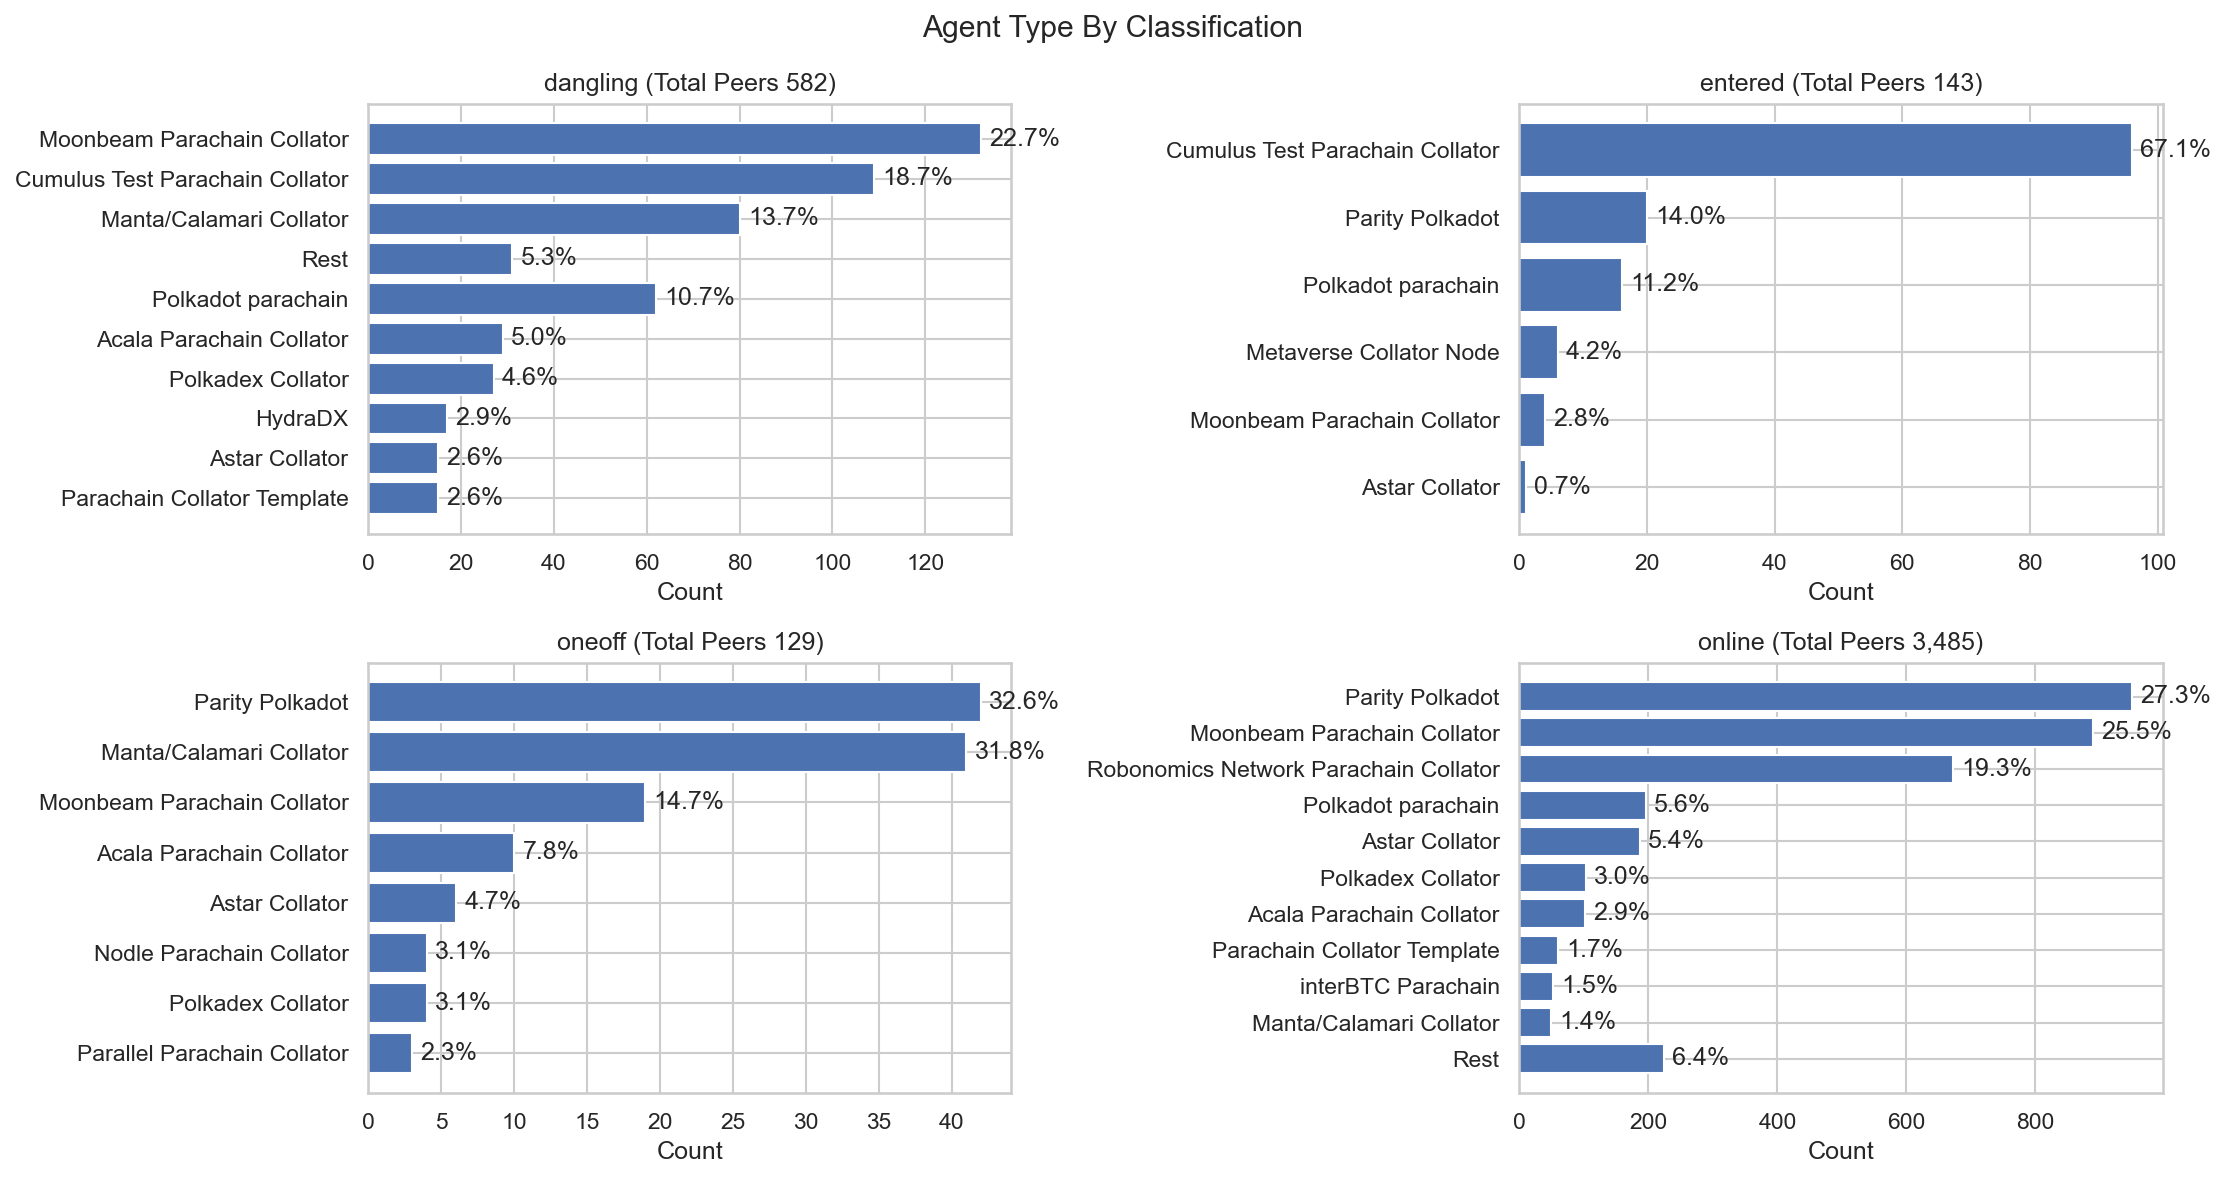

In [63]:
from matplotlib import ticker
from typing import Optional

fig, axs = plt.subplots(2, 2, figsize=[15, 8], dpi=150)

for idx, node_class in enumerate(sorted(agents.keys())):
    ax = fig.axes[idx]

    df = agents[node_class]

    def get_client(agent_version: str) -> Optional[str]:
        a = polkadot_version(agent_version)
        if a is None:
            return None
        return a.client
    
    df["client"] = df.apply(lambda row: get_client(row.agent_version), axis=1)

    agent_names_df = df \
        .groupby(by=["client"], as_index=False) \
        .sum(numeric_only=True) \
        .sort_values('count', ascending=False)
    agent_names_total = agent_names_df["count"].sum()

    result = agent_names_df.nlargest(10, columns="count")
    other_count = agent_names_df.loc[~agent_names_df["client"].isin(result["client"]), "count"].sum()

    if other_count > 0:
        result.loc[len(result)] = ['Rest', 0, other_count]

    agent_names_df = result

    bar = ax.barh(agent_names_df["client"], agent_names_df["count"])
    ax.bar_label(bar, padding=4,
                 labels=["%.1f%%" % (100 * val / agent_names_total) for val in agent_names_df["count"]])

    ax.set_xlabel("Count")
    ax.set_title(f"{node_class.lower()} (Total Peers {fmt_thousands(agent_names_total)})")
    ax.invert_yaxis()

fig.suptitle(f"Agent Type By Classification")

fig.set_tight_layout(True)

if len(agents.keys()) < len(fig.axes):
    for ax in fig.axes[len(agents.keys()):]:
        fig.delaxes(ax)


In [80]:
df = db_client.get_crawl_agent_versions(threshold=0)
df

Using cache file .cache/get_crawl_agent_versions-eefd14a692bc5fb996ddea557d70ac24b7ff7c831dfd0c3ebdb23e309ad9c9b9.pickle for get_crawl_agent_versions...


,crawl_id,started_at,agent_version,count
0,10995,2023-10-09 00:15:31.811880192,Zeitgeist Node/v0.4.0-bb0e6716cc3 (tightfisted...,1
1,10995,2023-10-09 00:15:31.811880192,Parity Polkadot/v1.1.0-f60318f6868 (WEB3TF-1 t...,1
2,10995,2023-10-09 00:15:31.811880192,Astar Collator/v5.18.1-67629371422 (greasy-jou...,1
3,10995,2023-10-09 00:15:31.811880192,Manta/Calamari Collator/v4.3.0-35075ed9340 (sa...,1
4,10995,2023-10-09 00:15:31.811880192,Parity Polkadot/v1.1.0-f60318f6868 (STAKEWORLD...,1
...,...,...,...,...
611045,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.0.0-1ed6e2e50a4 (dg91XV4i),1
611046,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.0.0-1ed6e2e50a4 (***NN***),1
611047,11065,2023-10-10 11:15:24.887352064,Unique Node/v0.9.43-ebc13786903 (extra-large-b...,1
611048,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.1.0-6a897f06942 (ashamed-co...,1


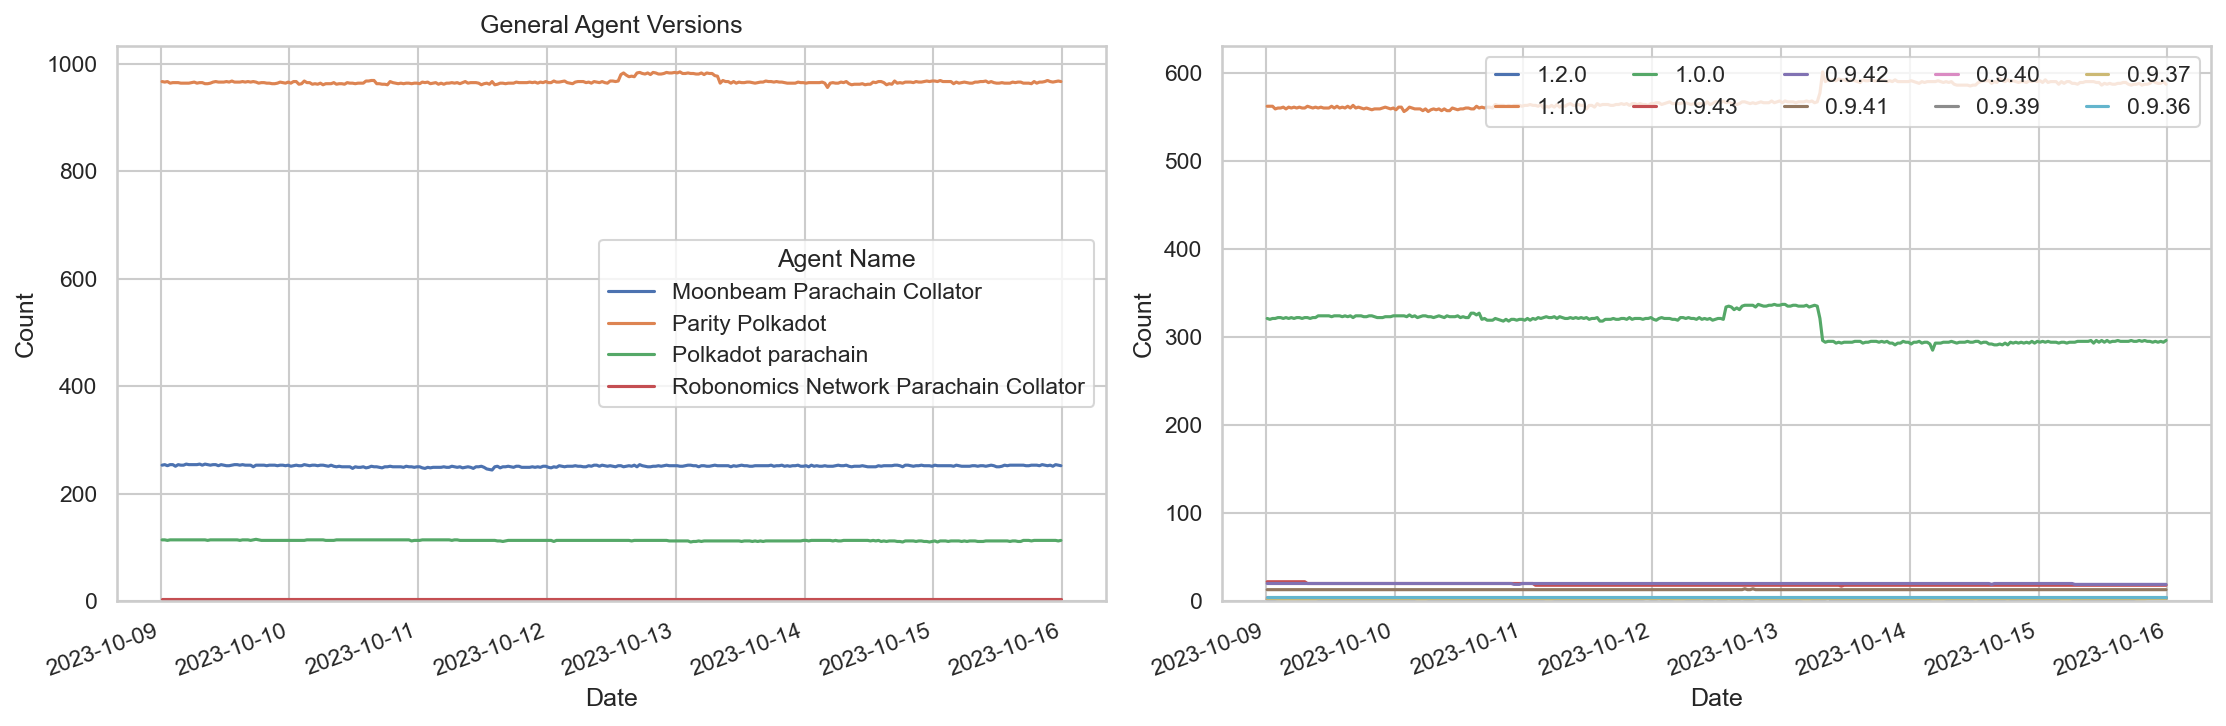

In [99]:
from lib.lib_fmt import thousands_ticker_formatter


def get_client(agent_version: str) -> Optional[str]:
    a = polkadot_version(agent_version)
    if a is None:
        return None
    return a.client


def get_version(agent_version: str) -> Optional[str]:
    a = polkadot_version(agent_version)
    if a is None:
        return None
    return a.version()

df["client"] = df.apply(lambda row: get_client(row["agent_version"]), axis=1)
df["version"] = df.apply(lambda row: get_version(row["agent_version"]), axis=1)

polkadot_clients = [
    "Parity Polkadot",
    "Moonbeam Parachain Collator",
    "Robonomics Network Parachain Collator",
    "Polkadot parachain"
]

group = df[df["client"].isin(polkadot_clients)] \
    .groupby(by=['crawl_id', 'started_at', 'client'], as_index=False) \
    .sum(numeric_only=True) \
    .sort_values(['started_at', 'count'], ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5], dpi=150)

for name in sorted(group["client"].unique()):
    data = group[group["client"] == name]
    ax1.plot(data["started_at"], data["count"], label=name)

ax1.set_ylim(0)
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
for tick in ax1.get_xticklabels():
    tick.set_rotation(20)
    tick.set_ha('right')
ax1.legend(title="Agent Name")
ax1.set_title("General Agent Versions")


group = df[df["client"] == polkadot_clients[0]] \
    .groupby(by=['crawl_id', 'started_at', 'version'], as_index=False) \
    .sum(numeric_only=True) \
    .sort_values(['started_at', 'count'], ascending=False)

# Find 10 most widely used agent versions
filter_group = group \
    .groupby(by="version", as_index=False) \
    .mean(numeric_only=True) \
    .sort_values('count', ascending=False)
filter_group = filter_group.head(10)

for version in reversed(sorted(group["version"].unique())):
    if version not in set(filter_group["version"]):
        continue
    data = group[group["version"] == version].sort_values('started_at', ascending=False)
    ax2.plot(data["started_at"], data["count"], label=version)

ax2.set_ylim(0)
ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
for tick in ax2.get_xticklabels():
    tick.set_rotation(20)
    tick.set_ha('right')
ax2.legend()
# ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: "%.1fk" % (x / 1000)))
# 
ax2.set_title(f"Top 10 \"{polkadot_clients[0]}\" Versions")
ax2.legend(handlelength=1.0, ncols=5)
fig.set_tight_layout(True)

In [93]:
df

,crawl_id,started_at,agent_version,count,client,version,version_sort
1,10995,2023-10-09 00:15:31.811880192,Parity Polkadot/v1.1.0-f60318f6868 (WEB3TF-1 t...,1,Parity Polkadot,1.1.0,1.1
4,10995,2023-10-09 00:15:31.811880192,Parity Polkadot/v1.1.0-f60318f6868 (STAKEWORLD...,1,Parity Polkadot,1.1.0,1.1
5,10995,2023-10-09 00:15:31.811880192,Parity Polkadot/v1.0.0-1ed6e2e50a4 (10081),1,Parity Polkadot,1.0.0,1.0
8,10995,2023-10-09 00:15:31.811880192,Moonbeam Parachain Collator/v0.29.0-a1110b6657...,1,Moonbeam Parachain Collator,0.29.0,0.29
9,10995,2023-10-09 00:15:31.811880192,Polkadot parachain/v1.1.0-783579b4a49 (polkado...,1,Polkadot parachain,1.1.0,1.1
...,...,...,...,...,...,...,...
611043,11065,2023-10-10 11:15:24.887352064,Moonbeam Parachain Collator/v0.33.0-63160c774d...,1,Moonbeam Parachain Collator,0.33.0,0.33
611045,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.0.0-1ed6e2e50a4 (dg91XV4i),1,Parity Polkadot,1.0.0,1.0
611046,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.0.0-1ed6e2e50a4 (***NN***),1,Parity Polkadot,1.0.0,1.0
611048,11065,2023-10-10 11:15:24.887352064,Parity Polkadot/v1.1.0-6a897f06942 (ashamed-co...,1,Parity Polkadot,1.1.0,1.1
